# Customer Segmentation

Using techniques like RFM analysis and unsupervised learning to segment customers by value, behavior, and lifecycle — with the goal of retention, personalization, and targeting.

## Setup + RFM Feature Engineering

🎯 Goal:

Create a table with Recency, Frequency, and Monetary value for each customer based on their transaction history.

🗂️ Steps:
1.	Import necessary libraries
2.	Load the cleaned dataset
3.	Convert Order_Date to datetime
4.	Set a reference date (usually 1 day after the last order)
5.	Aggregate per Customer_ID:
- Recency: Days since last order
- Frequency: Number of unique orders
- Monetary: Total sales or total profit

In [13]:
# Step 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from datetime import timedelta

# Step 2: Load data
data = pd.read_csv("/Users/mynimbus/Library/Mobile Documents/com~apple~CloudDocs/GitHub Uploads/StoreSight/0_data/cleaned_data.csv")
data['Order_Date'] = pd.to_datetime(data['Order_Date'])

# Step 3: Define Reference Date
reference_date = data['Order_Date'].max() + timedelta(days=1)
print("🗓️ Reference Date for RFM:", reference_date.date())

# Step 4: RFM Calculation
rfm_df = data.groupby('Customer_ID').agg({
    'Order_Date': lambda x: (reference_date - x.max()).days,
    'Order_ID': 'nunique',
    'Sales': 'sum'
}).reset_index()

# Step 5: Rename columns
rfm_df.columns = ['Customer_ID', 'Recency', 'Frequency', 'Monetary']

# Step 6: Preview
print("✅ RFM table created. Sample:")
display(rfm_df.head())

🗓️ Reference Date for RFM: 2016-01-01
✅ RFM table created. Sample:


,Customer_ID,Recency,Frequency,Monetary
0,AA-10315102,359,2,544.656
1,AA-10315120,960,1,2713.410
2,AA-10315139,150,4,2955.798
3,AA-103151402,185,2,4780.552
4,AA-103151404,819,2,753.508


## 📊 RFM Table – Initial Observations

### 🗓️ Reference Date: 2016-01-01  
The RFM table was created successfully with Recency, Frequency, and Monetary values for each customer.



### 🔍 Sample Insights:

| Customer_ID     | Recency | Frequency | Monetary | Interpretation              |
|------------------|---------|-----------|----------|-----------------------------|
| AA-10315102      | 359     | 2         | $544.66  | Inactive for ~1 year, low value – Possibly Lost |
| AA-10315120      | 960     | 1         | $2713.41 | Very old one-time buyer – High Risk |
| AA-10315139      | 150     | 4         | $2955.80 | Recently active and valuable – Potential Champion |
| AA-103151402     | 185     | 2         | $4780.55 | Active with high spend – Big Spender |
| AA-103151404     | 819     | 2         | $753.51  | Inactive, low-mid value – At Risk |



### ✅ Key Takeaways:

- **Recency** varies widely — some customers are highly inactive (>2 years).
- **Frequency** is generally low — opportunity for loyalty programs.
- Some customers show **high spend with low frequency** — ideal for targeted retention.



📌 Next: Score customers using quantiles and classify them into strategic behavioral segments.

---

## Advanced RFM-Based Segmentation (Scoring + Segments)

🎯 Goal:

Score customers on Recency, Frequency, and Monetary behavior using quantiles (1–5), and map them into descriptive segments like Champions, Loyal, At Risk, and Lost.


🗂️ Steps:
.	Assign quantile scores (1–5) to R, F, M
2.	Concatenate RFM scores into an RFM_Segment (e.g., R5F4M3)
3.	Create a Total_RFM_Score = R + F + M
4.	Map to descriptive customer segments using logic-based rules


In [14]:
# Step 1: Assign quantile scores
rfm_df['R_Score'] = pd.qcut(rfm_df['Recency'], 5, labels=[5, 4, 3, 2, 1]).astype(int)
rfm_df['F_Score'] = pd.qcut(rfm_df['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5]).astype(int)
rfm_df['M_Score'] = pd.qcut(rfm_df['Monetary'], 5, labels=[1, 2, 3, 4, 5]).astype(int)

# Step 2: Combine into RFM segment string
rfm_df['RFM_Segment'] = rfm_df['R_Score'].astype(str) + rfm_df['F_Score'].astype(str) + rfm_df['M_Score'].astype(str)

# Step 3: Create total RFM score
rfm_df['RFM_Score'] = rfm_df[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)

# Step 4: Define customer segment mapping
def map_segment(r, f, m):
    if r == 5 and f >= 4 and m >= 4:
        return 'Champion'
    elif r >= 4 and f >= 3:
        return 'Loyal'
    elif r >= 3 and f <= 2 and m <= 2:
        return 'Potential'
    elif r <= 2 and f >= 3:
        return 'At Risk'
    elif r == 1 and f == 1:
        return 'Lost'
    else:
        return 'Others'

rfm_df['Segment'] = rfm_df.apply(lambda row: map_segment(row['R_Score'], row['F_Score'], row['M_Score']), axis=1)

# Preview result
display(rfm_df.head())
rfm_df['Segment'].value_counts()

,Customer_ID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score,Segment
0,AA-10315102,359,2,544.656,3,4,4,344,11,Others
1,AA-10315120,960,1,2713.410,1,1,5,115,7,Lost
2,AA-10315139,150,4,2955.798,4,5,5,455,14,Loyal
3,AA-103151402,185,2,4780.552,4,4,5,445,13,Loyal
4,AA-103151404,819,2,753.508,2,4,4,244,10,At Risk


Segment
Others       6325
At Risk      3565
Loyal        3490
Potential    1848
Champion     1282
Lost          905
Name: count, dtype: int64

🧾 Observations from Customer Segmentation:

📊 Segment Distribution:
- Others: 6,325 customers — This is the largest segment, consisting of infrequent buyers or low-value customers.
- At Risk: 3,565 customers — Customers who have shown good frequency but haven’t purchased recently. Likely candidates for reactivation strategies.
- Loyal: 3,490 customers — Regular and high-frequency buyers with solid profitability. Great target for loyalty programs.
- Potential: 1,848 customers — Customers with good recency and monetary value but lower frequency. Good target for nurturing campaigns.
- Champion: 1,282 customers — High-value customers who are recent, frequent buyers. Top-tier customers to retain and upsell.
- Lost: 905 customers — Inactive customers who haven’t bought in a long time. Re-engagement efforts required to win them back.

⸻

✅ Insights:
1.	Loyal and Champion Segments:
- Loyal (3,490) and Champion (1,282) segments are your core business. They contribute the most to profitability and should be the focus of retention strategies, rewards, and exclusive offers.
2.	At Risk and Potential Segments:
- t Risk (3,565) customers are active but lacking recent engagement. Implement reactivation campaigns, targeting them with personalized discounts or reminders.
- Potential (1,848) customers have good Monetary but low Frequency. Focus on nurturing these customers with cross-sell or upsell opportunities.
3.	Lost Segment:
- Lost (905) customers represent a small portion of the overall customer base but require significant effort to re-engage. Focus on special promotions to bring them back or run exit surveys to understand why they left.
4.	Others Segment:
- Others (6,325) represents a large portion of low-engagement customers. These could be one-time buyers. Consider offering incentives to convert them to loyal customers.

----

## KMeans Clustering (Behavioral Profiling)

🎯 Objective:

Use KMeans clustering to group customers based on their Recency, Frequency, and Monetary values, revealing more detailed behavioral profiles that go beyond RFM.

By clustering, we’ll find:
- Hidden customer behaviors
- Natural groupings of customers based on purchase patterns

⸻

🗂️ Steps:
1.	Select features for clustering (Recency, Frequency, Monetary)
2.	Scale the data using StandardScaler (important for KMeans)
3.	Apply KMeans clustering and choose an optimal number of clusters (typically using the Elbow method)
4.	Visualize clusters:
Use PCA (Principal Component Analysis) to reduce the dimensionality to 2D
    - Plot the clusters to understand customer behaviors visually

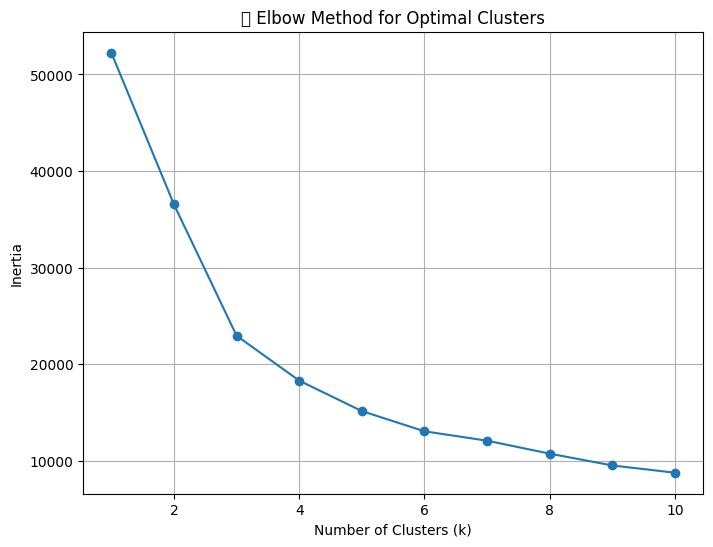

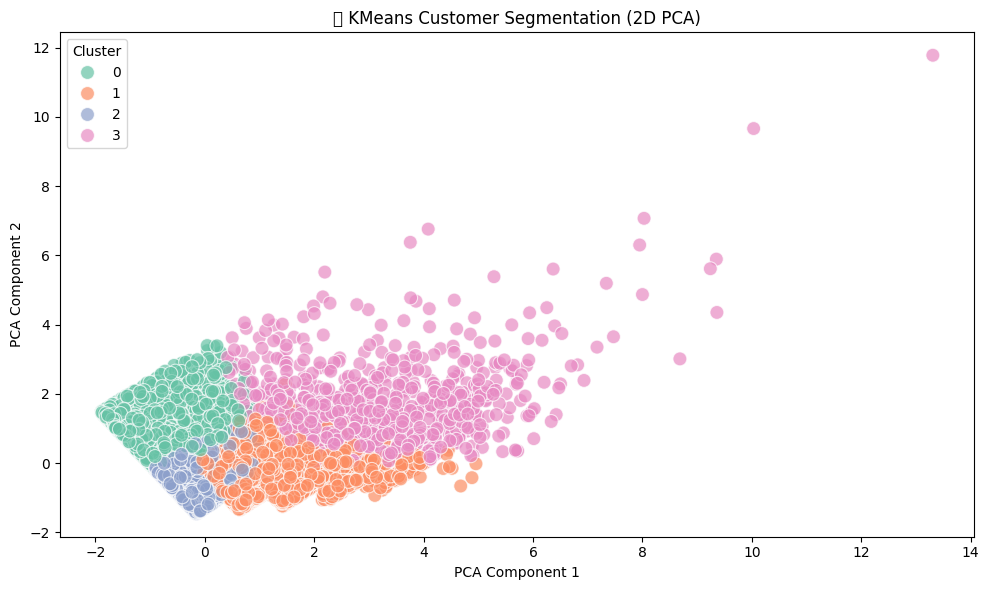

In [15]:
# Step 1: Select Features for Clustering
features = rfm_df[['Recency', 'Frequency', 'Monetary']]

# Step 2: Standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Step 3: Apply KMeans Clustering
from sklearn.cluster import KMeans

# Use Elbow method to find optimal k
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plot Elbow curve
plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia, marker='o')
plt.title("📉 Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

# Based on the elbow plot, choose k (let's say k=4 for simplicity)
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

# Step 4: Add clusters to the dataframe
rfm_df['Cluster'] = clusters

# Step 5: Reduce to 2D using PCA for visualization
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

rfm_df['PCA1'] = pca_result[:, 0]
rfm_df['PCA2'] = pca_result[:, 1]

# Step 6: Plot Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm_df, x='PCA1', y='PCA2', hue='Cluster', palette='Set2', s=100, alpha=0.7)
plt.title("🧠 KMeans Customer Segmentation (2D PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

In [16]:
import plotly.express as px

# Step 1: 3D PCA Visualization
# Use PCA for dimensionality reduction (3 components)
pca_3d = PCA(n_components=3)
pca_result_3d = pca_3d.fit_transform(scaled_features)

# Add the PCA components and cluster labels to the dataframe
rfm_df['PCA1'] = pca_result_3d[:, 0]
rfm_df['PCA2'] = pca_result_3d[:, 1]
rfm_df['PCA3'] = pca_result_3d[:, 2]

# Step 2: Create an interactive 3D scatter plot with Plotly
fig = px.scatter_3d(
    rfm_df, 
    x='PCA1', y='PCA2', z='PCA3',
    color='Cluster', 
    title="🧠 KMeans Customer Segmentation (3D)",
    labels={"PCA1": "PCA Component 1", "PCA2": "PCA Component 2", "PCA3": "PCA Component 3"},
    color_discrete_sequence=px.colors.qualitative.Set2  # ✅ Correct usage
)

# Step 3: Show the plot
fig.show()

---

In [17]:
# Cluster Summary: Average values per cluster
cluster_summary = (
    rfm_df.groupby('Cluster')[['Recency', 'Frequency', 'Monetary', 'RFM_Score']]
    .mean()
    .round(2)
    .reset_index()
)

# Add customer count per cluster
cluster_summary['Customer_Count'] = rfm_df.groupby('Cluster')['Customer_ID'].nunique().values

# Sort by Monetary or RFM_Score for insight clarity (optional)
cluster_summary = cluster_summary.sort_values(by='Monetary', ascending=False)

# Display summary
print("📊 Customer Cluster Summary:")
display(cluster_summary)

# Save to CSV (optional, for backup or presentation)
cluster_summary.to_csv("cluster_summary.csv", index=False)

📊 Customer Cluster Summary:


,Cluster,Recency,Frequency,Monetary,RFM_Score,Customer_Count
3,3,318.08,2.77,3867.17,13.01,1055
1,1,250.37,2.46,833.04,12.24,4077
0,0,1012.09,1.09,444.61,6.49,5439
2,2,290.37,1.00,401.53,8.46,6844


---

# 🧠 Customer Segmentation Report (KMeans Clustering)

## 🎯 Objective:
Segment customers into behavior-based clusters using KMeans on **Recency**, **Frequency**, and **Monetary** data, enabling data-driven personalization and retention strategies.



## 📊 Cluster Summary:

| Cluster | Recency (↓ better) | Frequency (↑ better) | Monetary (↑ better) | RFM Score | Customer Count |
|---------|--------------------|----------------------|----------------------|-----------|----------------|
| 3       | 318.08             | 2.77                 | **3867.17**          | **13.01** | 1,055          |
| 1       | **250.37**         | 2.46                 | 833.04               | 12.24     | 4,077          |
| 2       | 290.37             | 1.00                 | 401.53               | 8.46      | 6,844          |
| 0       | **1012.09**        | **1.09**             | **444.61**           | **6.49**  | 5,439          |



## 🔍 Cluster Insights:

### 🟢 **Cluster 3 — Champions (Top-Tier Customers)**  
- **Recency**: Fairly recent (318 days)  
- **High Frequency & Very High Monetary**  
- Highest RFM Score (13.01)  
- **Most profitable cluster** despite smaller size  
> 🔥 **Action**: Reward with loyalty programs, early access, exclusive deals



### 🔵 **Cluster 1 — Loyal Mid-Spenders**  
- **Very recent buyers** (best Recency: 250 days)  
- Moderate Frequency and good RFM score (12.24)  
- Monetary is decent but not elite  
> ✅ **Action**: Nurture to upgrade them into Champions (Cluster 3). Focused promotions.



### 🟡 **Cluster 2 — Low Value / Dormant Buyers**  
- **Low Frequency** (1 purchase), moderate Recency (290 days)  
- Low Monetary and RFM Score  
- **Largest segment** (6,844 customers)  
> ⚠️ **Action**: Re-engagement campaign to revive — bundle offers, win-back emails



### 🔴 **Cluster 0 — Lost / Disengaged Customers**  
- **Very old Recency (1012 days)** and lowest Frequency  
- Low Monetary, lowest RFM Score  
> ❌ **Action**: Low priority — use light, low-cost marketing or exclude from premium campaigns



## ✅ Strategic Recommendations:

| Segment     | Action Plan                                                  |
|-------------|--------------------------------------------------------------|
| Champions   | Retain, delight, upsell — make them advocates                |
| Loyal       | Nurture with personalized campaigns and early VIP access     |
| Low Value   | Trigger reactivation incentives and tailored communication   |
| Lost        | Light retargeting or churn analysis to prevent future loss   |



## 📌 Final Thought:
Your business profits are likely concentrated in **Cluster 3 (Champions)**. With **just 1,055 customers**, they drive the most revenue. Invest in keeping them happy. Meanwhile, **Cluster 0 and 2** represent risk or lost opportunities — act wisely to convert or contain.